# Project № 2. European Soccer Database investigation

## Table of contents
<ul>
    <li><a href="#intro">Introduction</a></li>
    <li><a href="#dataextract">Data extraction and wrangling</a></li>
    <li><a href="#eda">Exploratory Data Analysis</a></li>
    <li><a href="#conc">Conclusion</a></li>
     <li><a href="#res">Resources</a></li>
   
</ul>

# <a id='intro'></a>
## Introduction
Soccer plays an important role in our society. It does not only entertain people, but keeps soccer players in good health condition as well as attracts huge amount of money during FIFA and other games. Such games gather millions of people on stadiums and in front of TVs. Many fans bet on their favorite teams.  Some of them win and a lot of them loose their money. In order to predict and to increase a possibility that the game score will be in their favor we will investigate the European Soccer Database provided by Hugo Mathien (https://www.kaggle.com/hugomathien/soccer).

The following questions will be explored during the analysis: 
* Do teams perform better when they play at home or away?
* Determine teams which performance significantly improved. 
* Does overall performance among all teams between 2008 and 2016 had been improved? 
* Are there any correlations between total number of goals and team attributes? Can we find correlation between team attributes? 




# <a id='dataextract'></a>
## Data extraction and wrangling
Data is stored in SQLite database. Initial data investigation was performed in DB browser for SQlite where tables, data types, relationship between tables, their Primary and Foreign keys were defined.

Queries were developed and tested in the DB browser and then, embended into the Python code in such way taht the Python script directly interacts with the existed database.  


In [22]:
#import packages: 
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image
from IPython.core.display import HTML  
% matplotlib inline



path = "./input/"
database = "database_soccer.sqlite"
conn = sqlite3.connect(database)
    
   

# extract list of countries
countries = pd.read_sql("""SELECT *
                           FROM Country;""", conn)
countries.drop(['id'], axis = 1, inplace = True)
# a list of countries:
countries

name
0       Belgium
1       England
2        France
3       Germany
4         Italy
5   Netherlands
6        Poland
7      Portugal
8      Scotland
9         Spain
10  Switzerland

In [23]:
# get country with its team and goals, away country with goals
goals_home_vs_away = pd.read_sql("""SELECT DISTINCT STRFTIME('%Y', date) AS year,
                                                    date AS full_date,
                                                    c.name AS country_name,
      	                                            home_team.team_long_name AS home_team,
                                                    match.home_team_api_id AS home_id,
      	                                            away_team.team_long_name AS away_team,
                                                    match.away_team_api_id AS away_id,
                       	                            home_team_goal,
                       	                            away_team_goal
                                     FROM match
                                     JOIN country AS c
                                       ON c.id = match.country_id
                                     JOIN League AS leag
                                       ON Leag.id = match.league_id
                                     LEFT JOIN team AS home_team
                                       ON home_team.team_api_id = match. home_team_api_id
                                     LEFT JOIN team AS away_team
                                       ON away_team.team_api_id = match.away_team_api_id
                                     ORDER BY 1  """, conn)

In [24]:
#get info about dataset:
goals_home_vs_away.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Data columns (total 9 columns):
year              25979 non-null object
full_date         25979 non-null object
country_name      25979 non-null object
home_team         25979 non-null object
home_id           25979 non-null int64
away_team         25979 non-null object
away_id           25979 non-null int64
home_team_goal    25979 non-null int64
away_team_goal    25979 non-null int64
dtypes: int64(4), object(5)
memory usage: 1.8+ MB


In [25]:
#check for duplicated lines
print("duplicated rows for team attirbutes:", goals_home_vs_away.duplicated(keep='first').sum())

duplicated rows for team attirbutes: 0


In the obtained dataset rows with NaN values and duplicated rows were not found 

In [26]:
#The data set is 
goals_home_vs_away.head()

year            full_date country_name          home_team  home_id  \
0  2008  2008-08-17 00:00:00      Belgium           KRC Genk     9987   
1  2008  2008-08-16 00:00:00      Belgium   SV Zulte-Waregem    10000   
2  2008  2008-08-16 00:00:00      Belgium  KSV Cercle Brugge     9984   
3  2008  2008-08-17 00:00:00      Belgium           KAA Gent     9991   
4  2008  2008-08-16 00:00:00      Belgium      FCV Dender EH     7947   

           away_team  away_id  home_team_goal  away_team_goal  
0       Beerschot AC     9993               1               1  
1   Sporting Lokeren     9994               0               0  
2     RSC Anderlecht     8635               0               3  
3          RAEC Mons     9998               5               0  
4  Standard de Liège     9985               1               3

In [27]:
# One can review a full data set in .csv file using cat function in the terminal or Excel 
goals_home_vs_away.to_csv('./datasets/goals_home_vs_away.csv')


In [28]:
"""
from DB extract team attributes

"""

team_attributes = pd.read_sql(""" SELECT STRFTIME('%Y', date) AS year,
                                            date AS full_date,
                                            team_api_id AS id,
                                            buildupplayspeed AS speed,
                                            buildupplaydribbling AS gribbing,
                                            buildupplaypassing AS pl_passing,
                                            chancecreationpassing AS cr_passing,
                                            chancecreationcrossing AS crossing,
                                            chancecreationshooting AS shooting,
                                            defencepressure AS pressure,
                                            defenceaggression AS aggression,
                                            defenceteamwidth AS width
                                    FROM Team_Attributes """, conn)
#get info about dataset:
team_attributes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 12 columns):
year          1458 non-null object
full_date     1458 non-null object
id            1458 non-null int64
speed         1458 non-null int64
gribbing      489 non-null float64
pl_passing    1458 non-null int64
cr_passing    1458 non-null int64
crossing      1458 non-null int64
shooting      1458 non-null int64
pressure      1458 non-null int64
aggression    1458 non-null int64
width         1458 non-null int64
dtypes: float64(1), int64(9), object(2)
memory usage: 136.8+ KB


*We can see thath only the gribbing column has null values and a number of null values is sagnificant. Due to this fact we can the drop gribbing column* 

In [29]:
team_attributes.drop(columns=['gribbing'], inplace = True)
team_attributes.info()
#make sure gribbing is dropped:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 11 columns):
year          1458 non-null object
full_date     1458 non-null object
id            1458 non-null int64
speed         1458 non-null int64
pl_passing    1458 non-null int64
cr_passing    1458 non-null int64
crossing      1458 non-null int64
shooting      1458 non-null int64
pressure      1458 non-null int64
aggression    1458 non-null int64
width         1458 non-null int64
dtypes: int64(9), object(2)
memory usage: 125.4+ KB


In [30]:
#check for duplicated rows
print("duplicated rows for team attirbutes:", team_attributes.duplicated(keep='first').sum())

duplicated rows for team attirbutes: 1


*One row with duplicated value was found. Drop it:* 

In [31]:
team_attributes.drop_duplicates(keep='first', inplace = True)

In [32]:
#recheck for duplicated rows
print("duplicated rows for team attirbutes:", team_attributes.duplicated(keep='first').sum())

duplicated rows for team attirbutes: 0


Datasets are quite clean. 

In [33]:
#save database to review data manually
team_attributes.to_csv('./datasets/team_attributes.csv')

<a id='eda'></a>
## Exploratory Data Analysis

In this section questions asked in introduction will be answered. Dataset will be investigated and some plots will be obtained. 

### Reserch Question # 1: Do teams perform better when they play at home or away?


To answer this question we will calculate the average number of goals per each team in each country and draw bar plots with normalized values. 

C:\Users\Boris\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


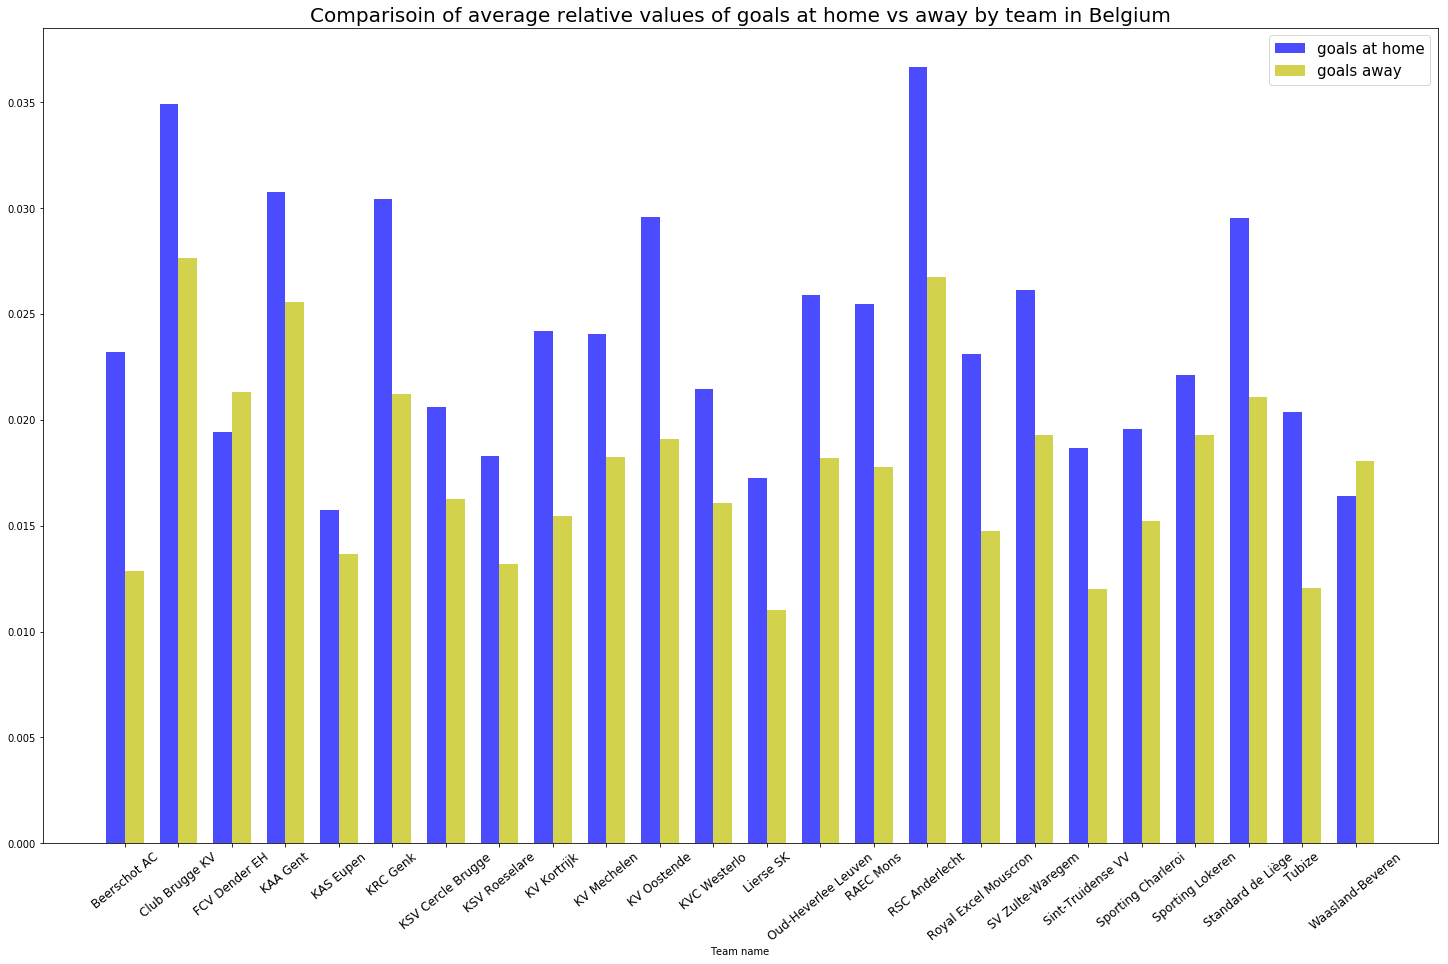

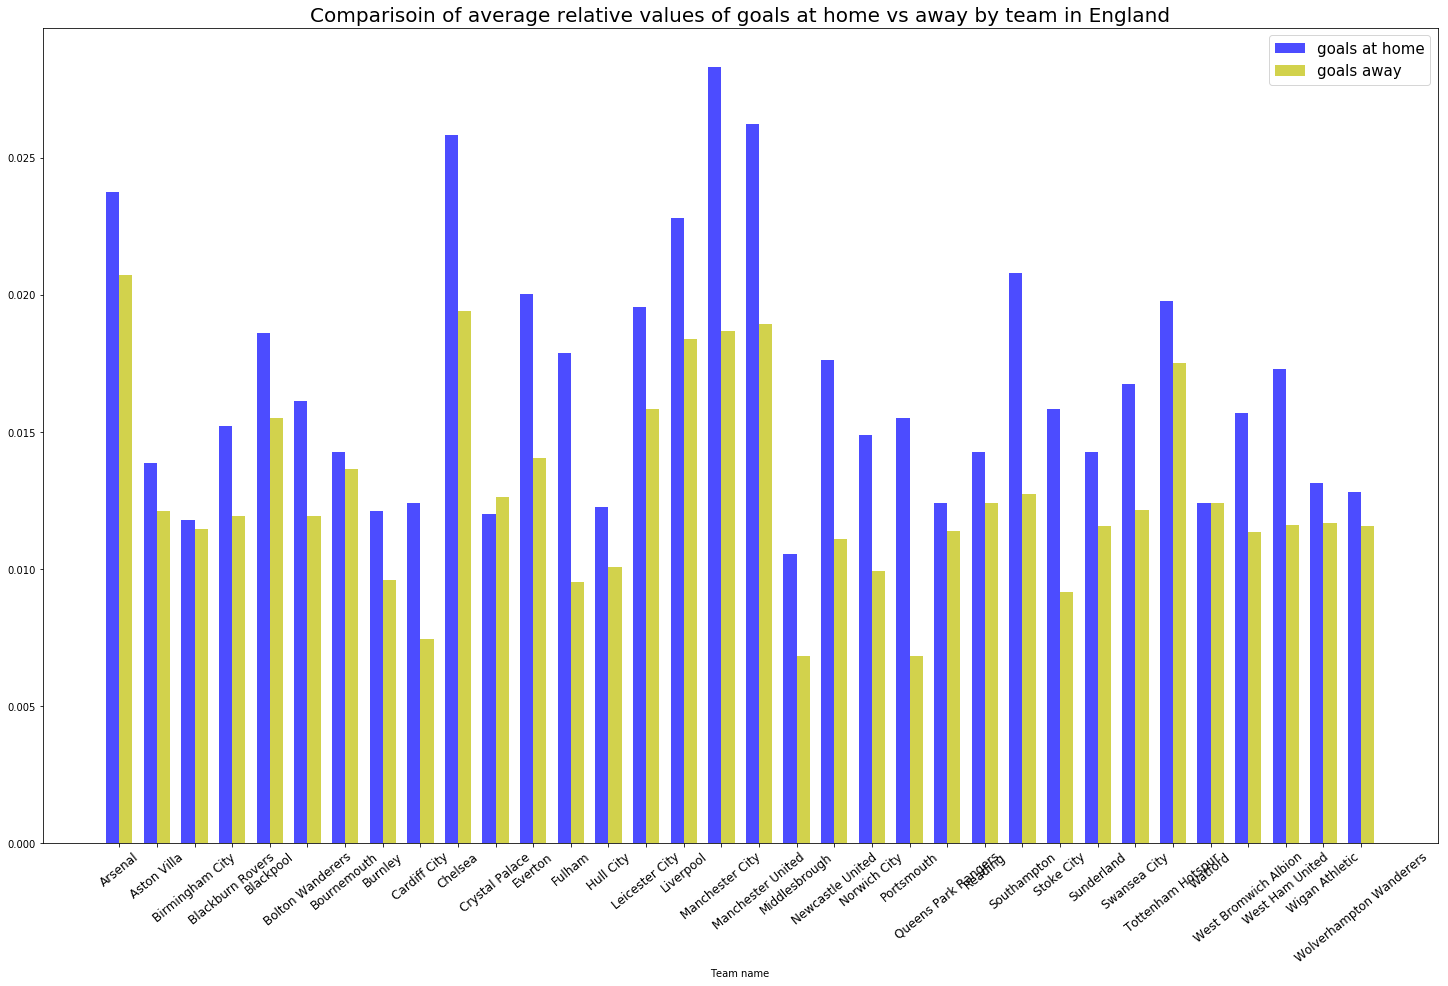

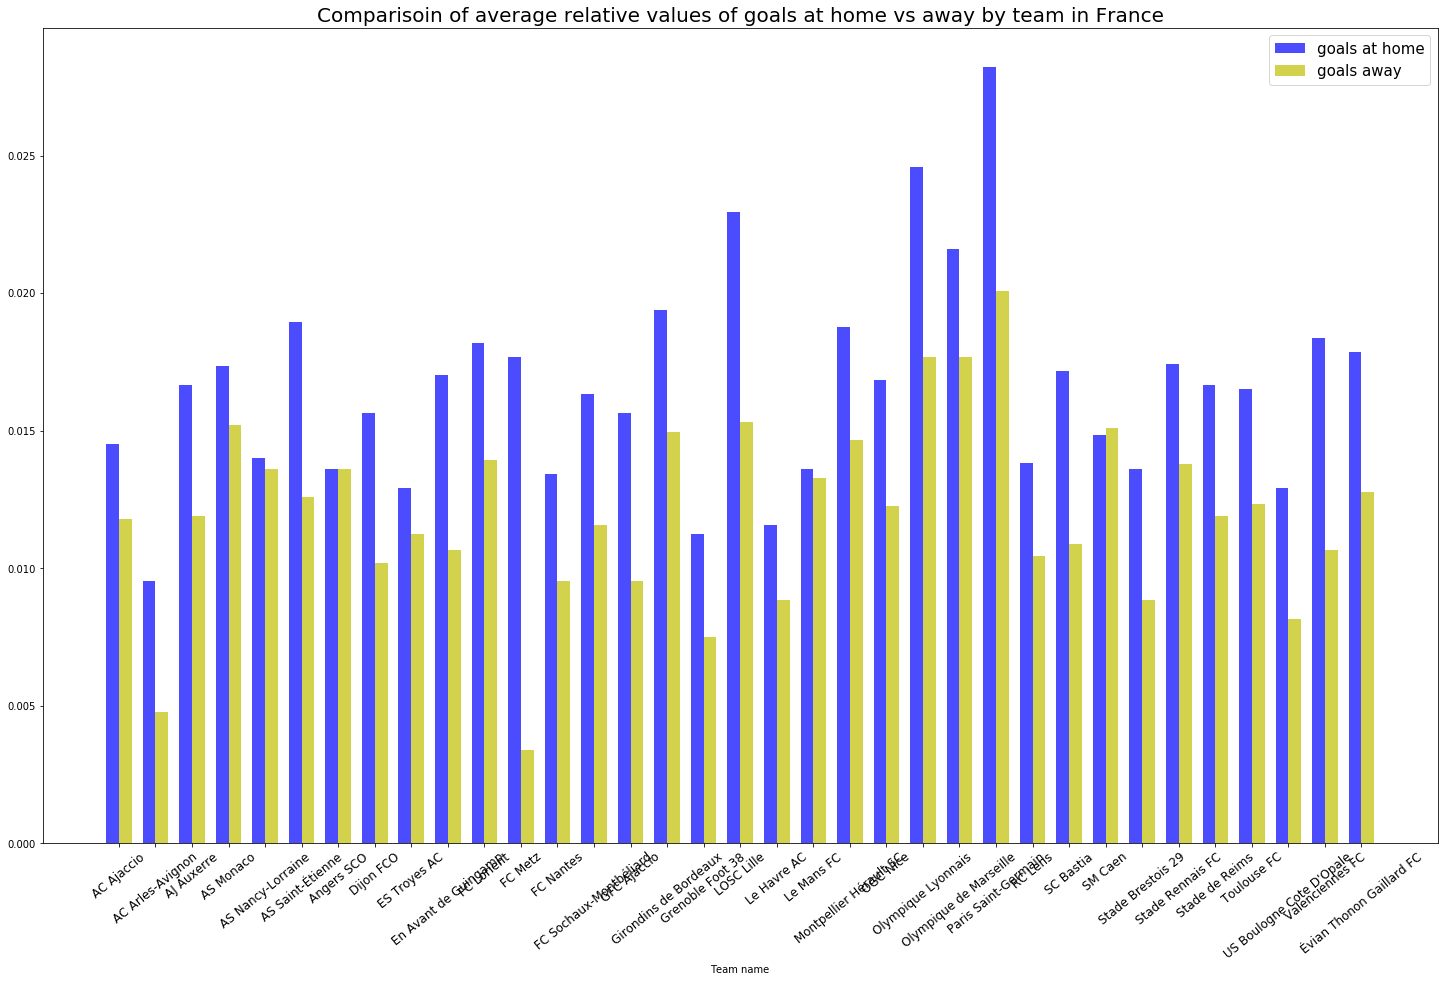

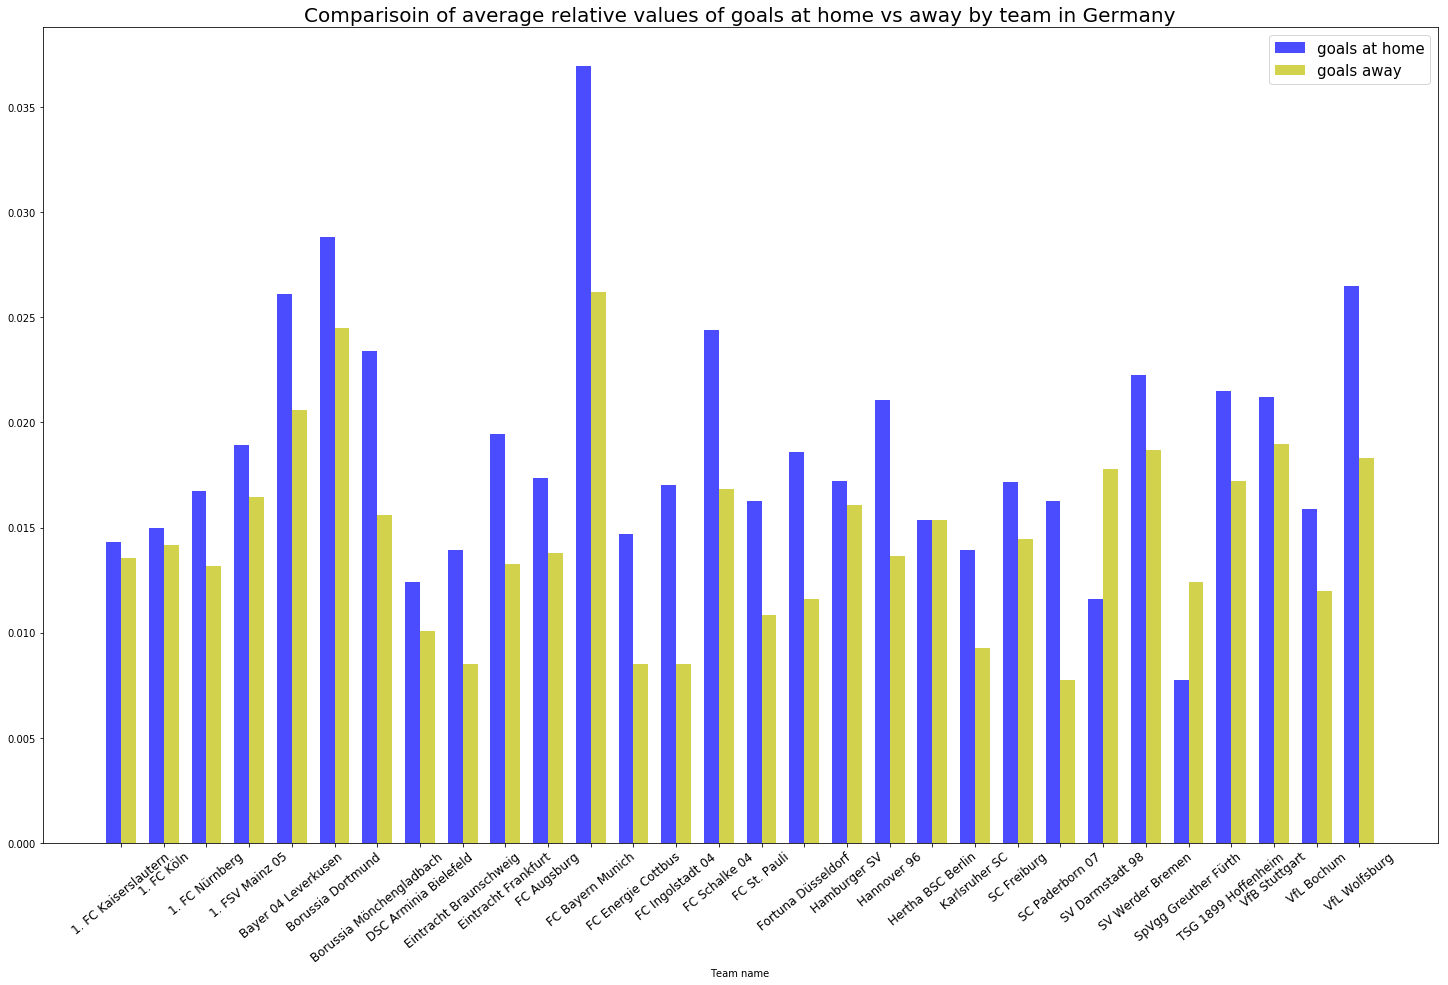

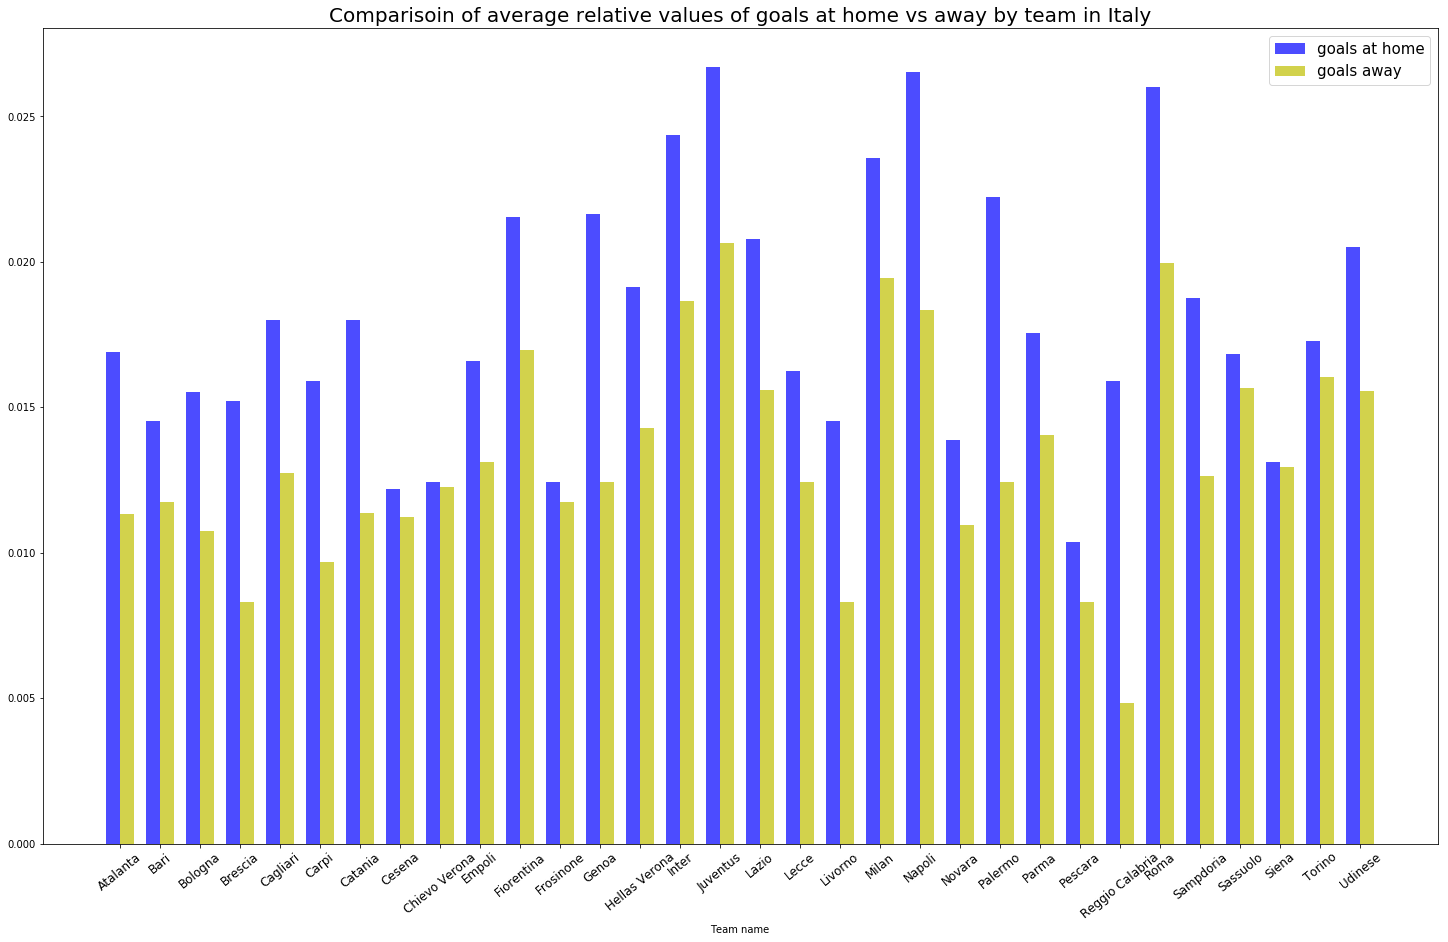

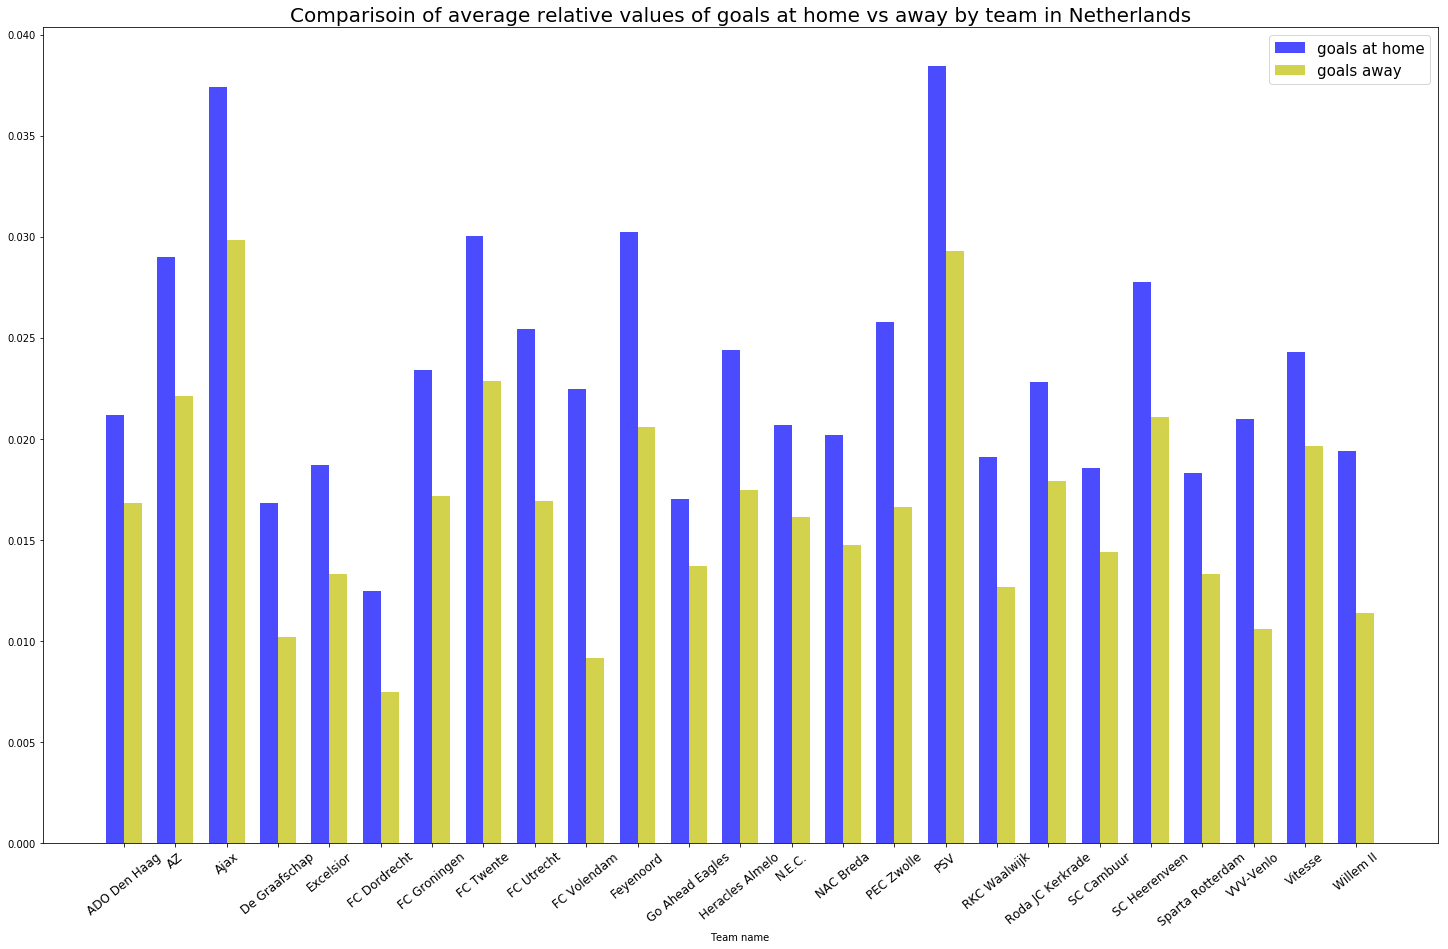

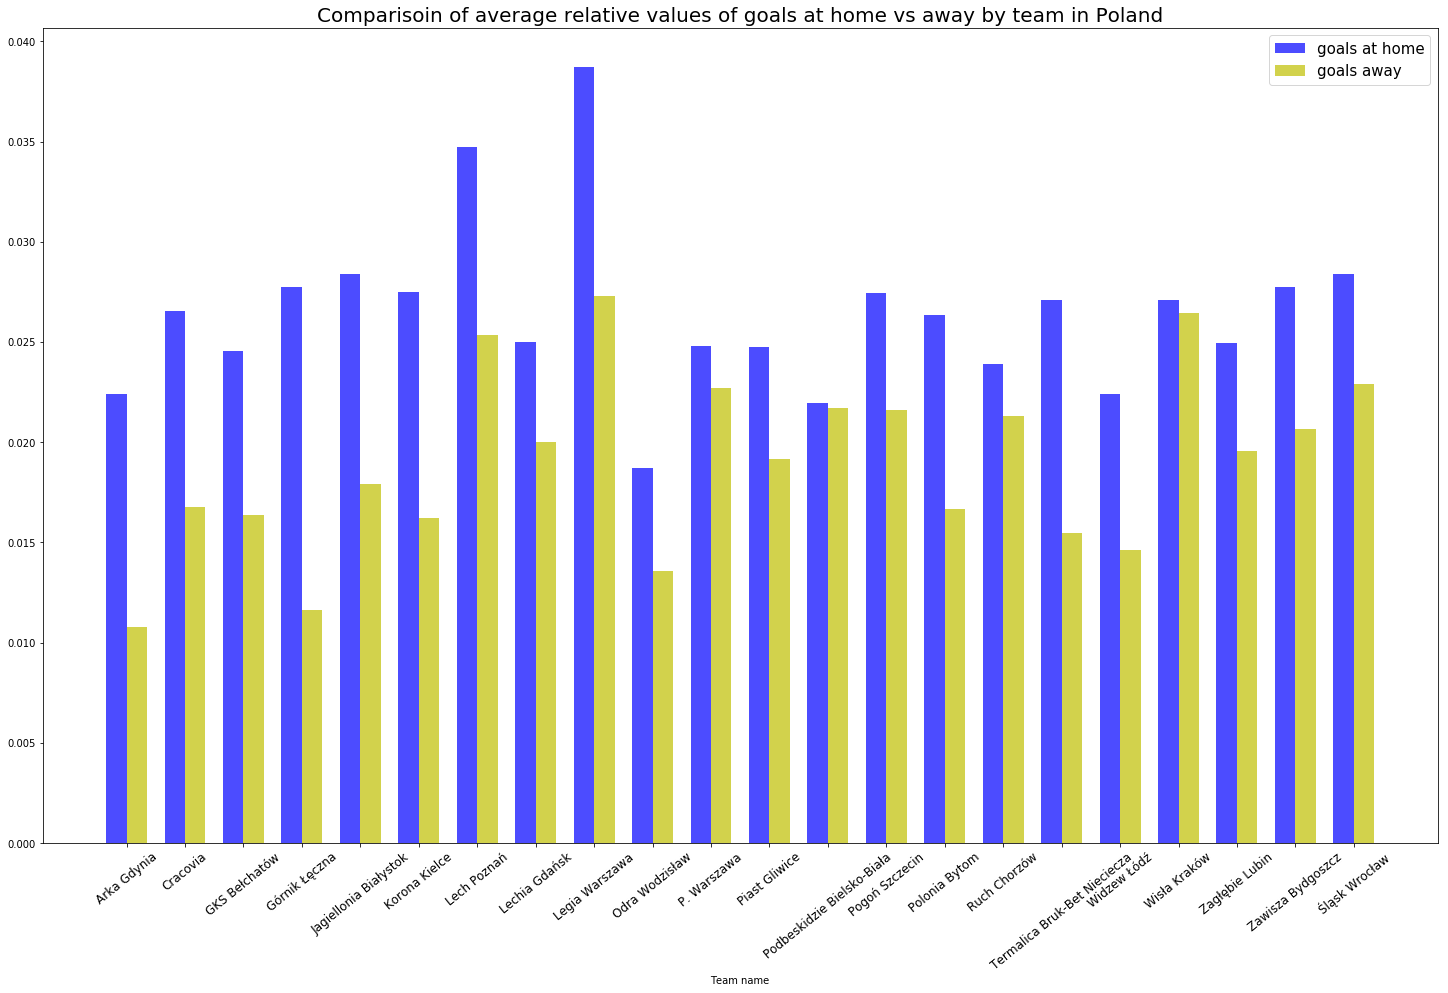

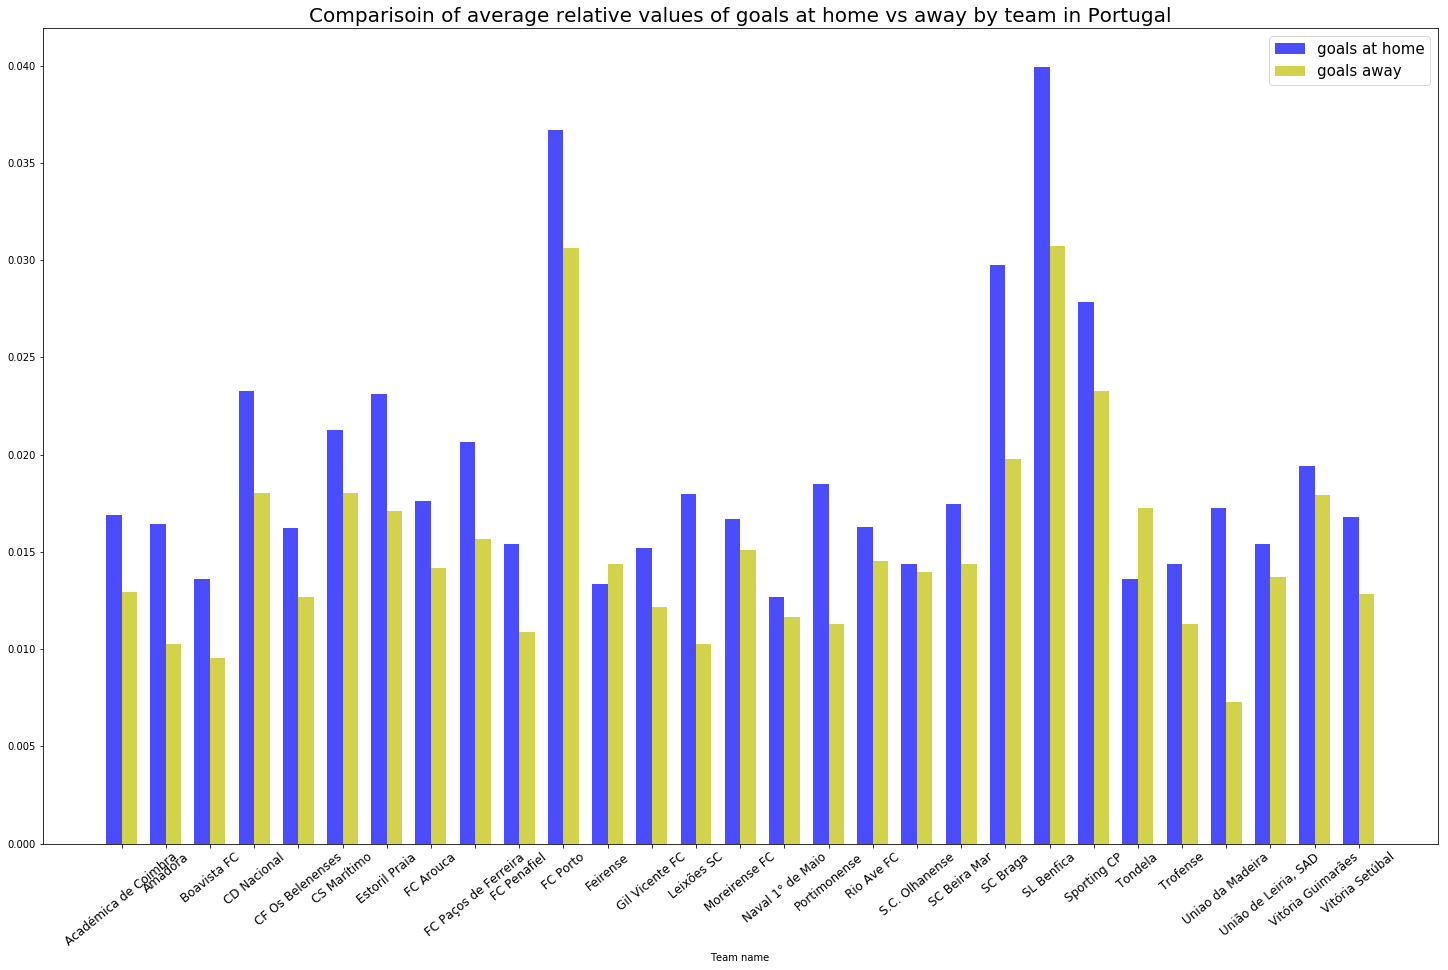

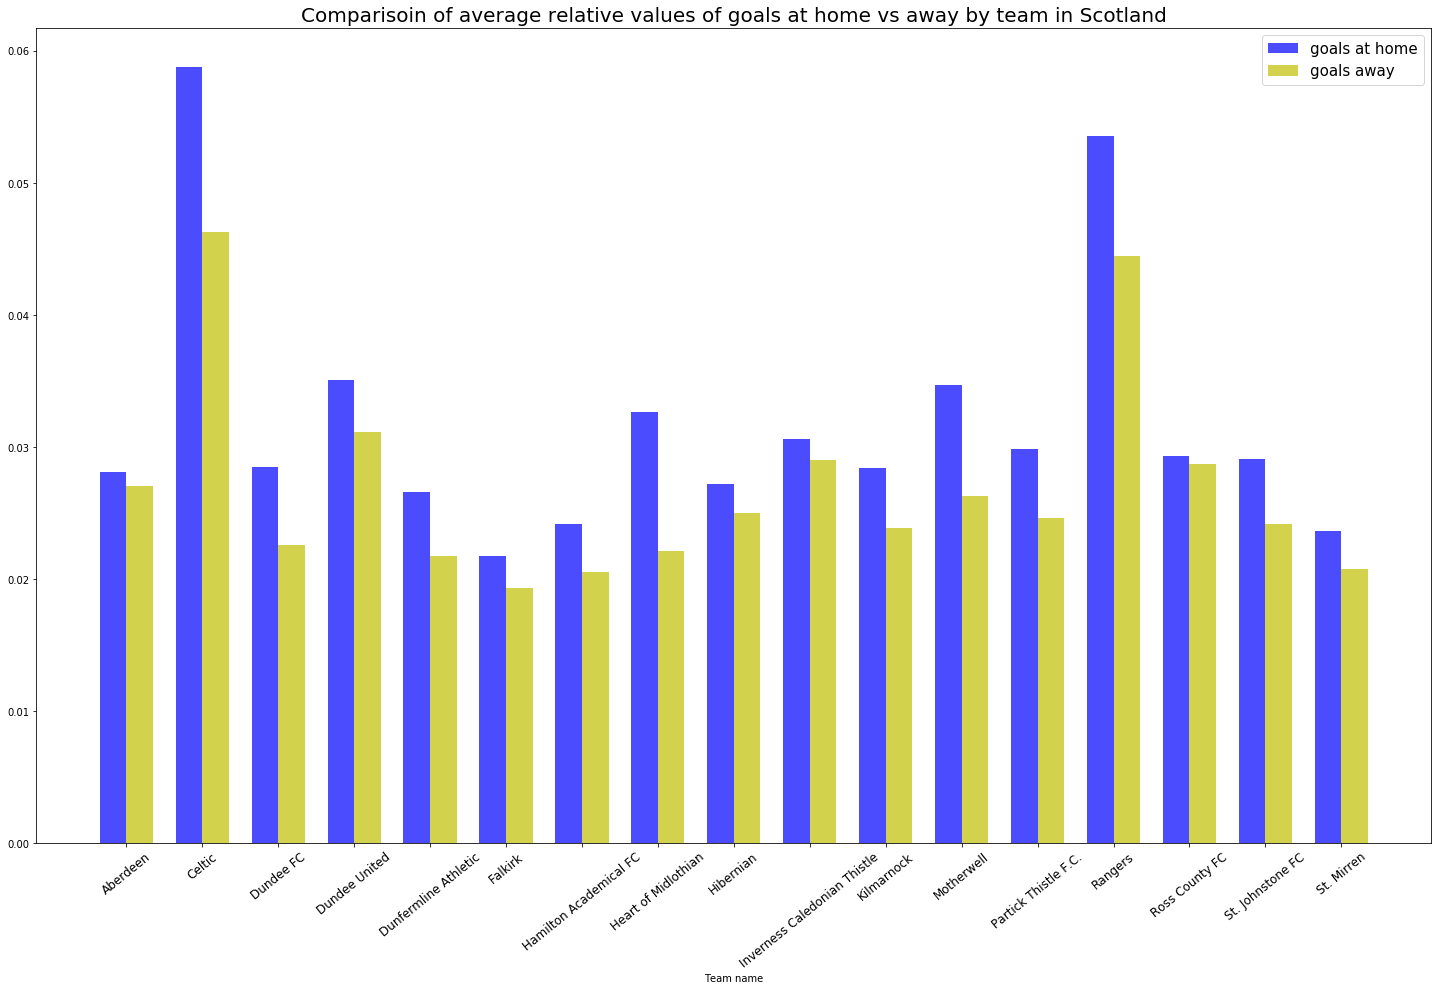

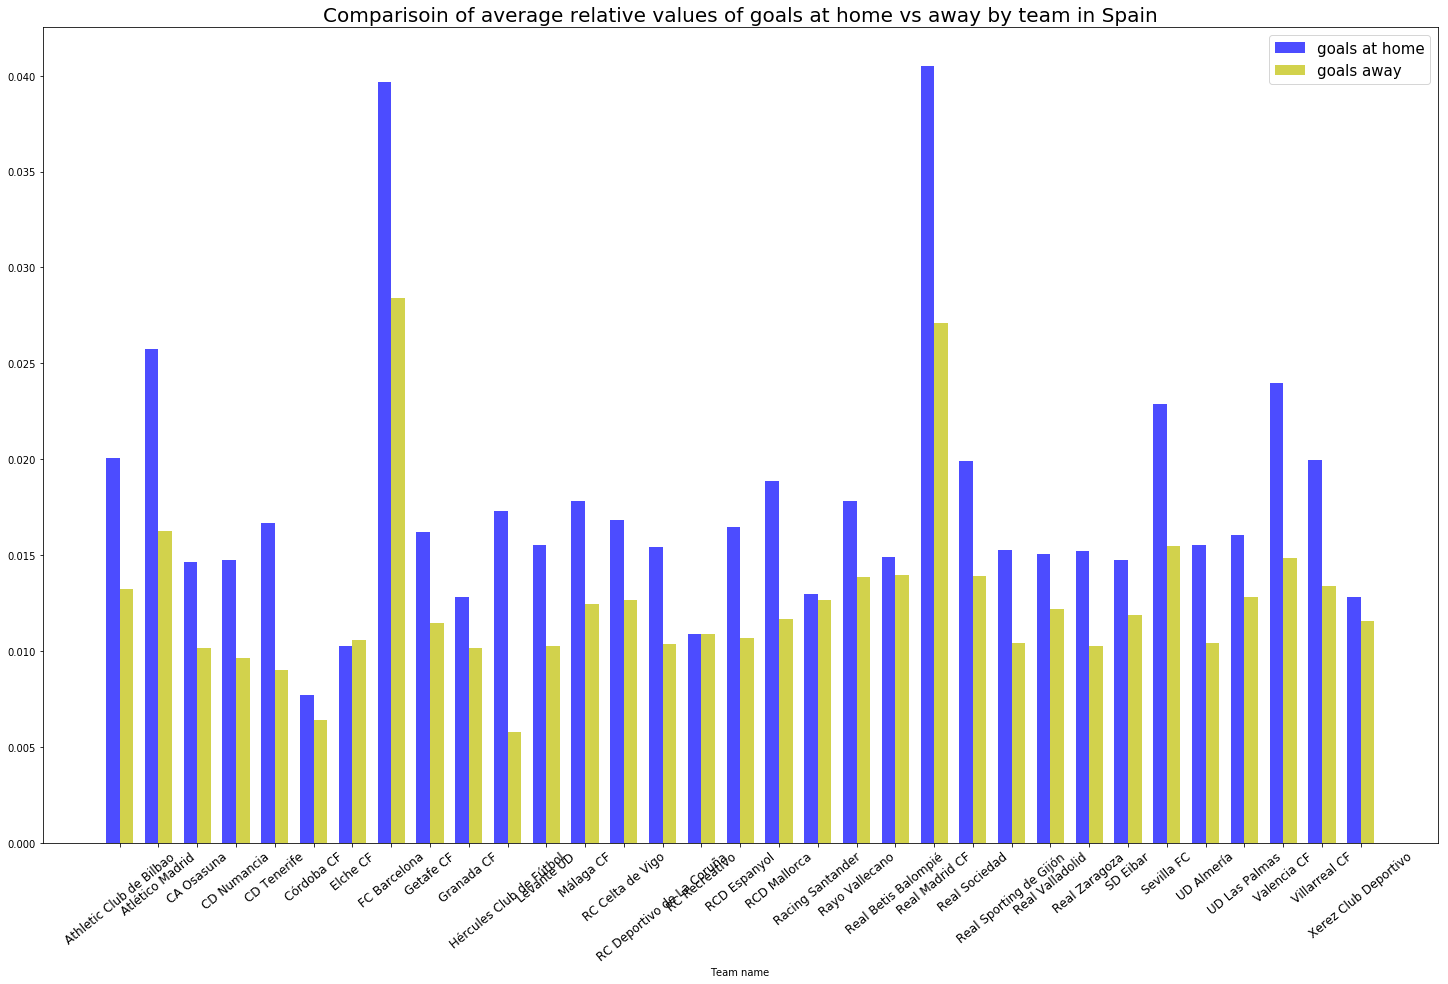

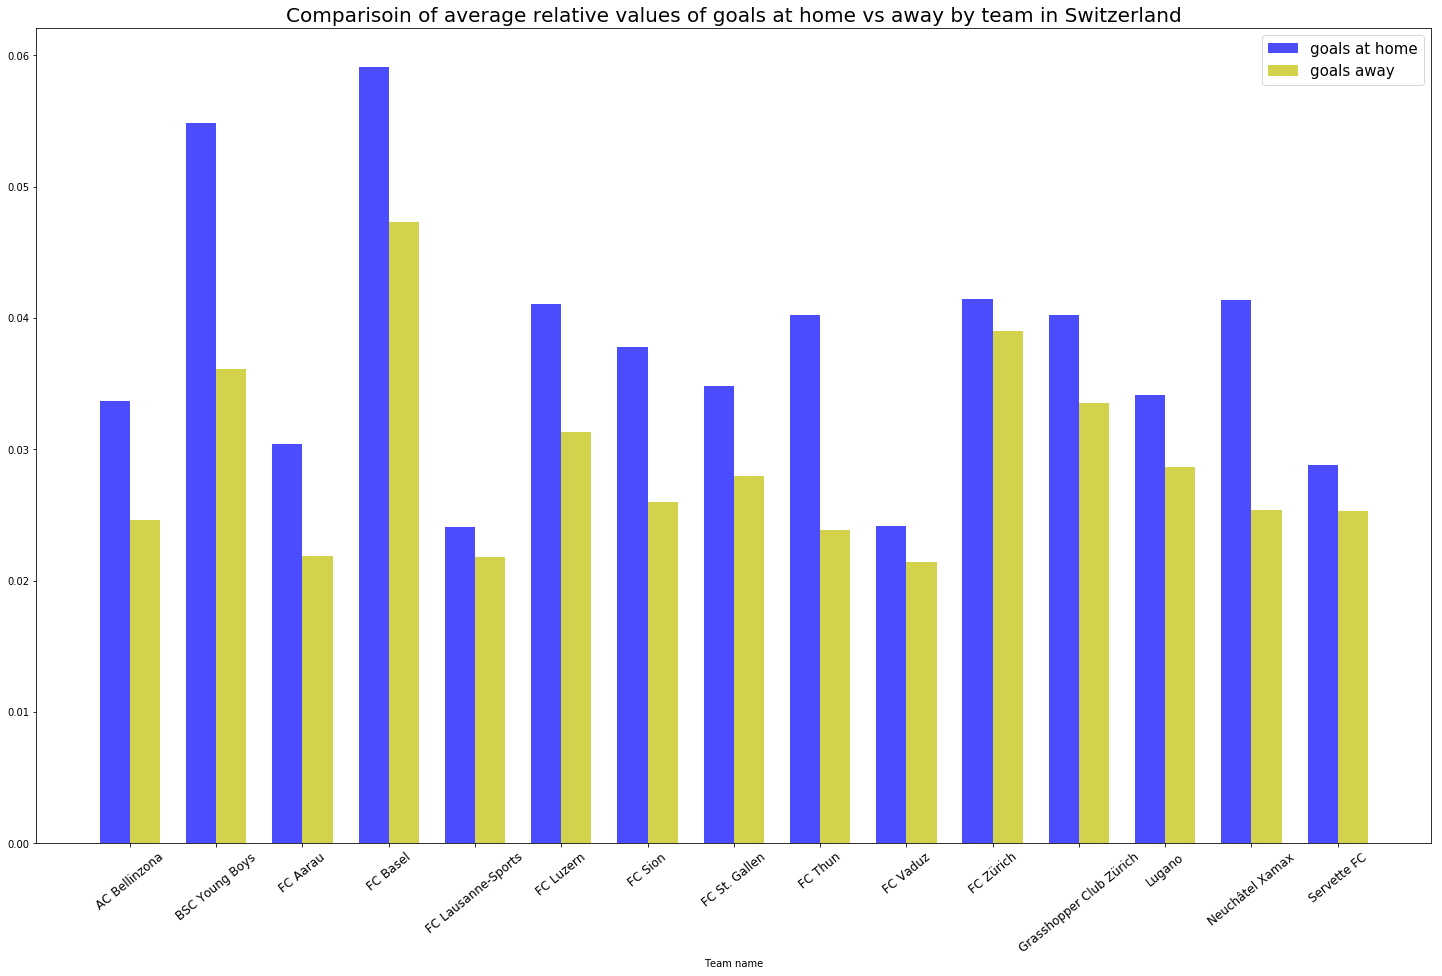

In [34]:
home_team_goal_avg = goals_home_vs_away[['country_name','home_team','home_team_goal']].groupby(['country_name','home_team'], as_index=False)['home_team_goal'].mean()
away_team_goal_avg = goals_home_vs_away[['country_name','away_team','away_team_goal']].groupby(['country_name','away_team'], as_index=False)['away_team_goal'].mean()
goals_home_away_avg = home_team_goal_avg.merge(away_team_goal_avg, left_on='home_team', right_on='away_team', how='inner')
goals_home_away_avg.rename(columns={'country_name_x' : 'country_name', 'home_team' : 'team_name', 'home_team_goal' : 'goals_at_home', 'away_team_goal':'goals_away'}, inplace = True)
goals_home_away_avg.drop(['away_team','country_name_y'], axis = 1, inplace=True)
home_team_goal_avg.to_csv('./datasets/home_teams_avg.csv')
away_team_goal_avg.to_csv('./datasets/away_teams_avg.csv')
goals_home_away_avg.to_csv('./datasets/goals_home_aways_avg.csv')
#avg_goals_country_appended = pd.DataFrame()
path = "./plots/"
i = 0
for country in countries.loc[:,'name']:
    avg_goals_country =  goals_home_away_avg[goals_home_away_avg['country_name'] == country]
    plt.subplots(figsize=(25,15))
    total = avg_goals_country['goals_at_home'].sum() + avg_goals_country['goals_away'].sum()
    avg_goals_country.loc[:,'goals_at_home'] = avg_goals_country.loc[:,'goals_at_home'] / total
    avg_goals_country.loc[:,'goals_away'] = avg_goals_country.loc[:,'goals_away'] / total
    if i == 0:
        avg_goals_country_appended = avg_goals_country
        i += 1
    else:
        avg_goals_country_appended = avg_goals_country_appended.append(avg_goals_country, ignore_index = True)
    ind = np.arange(avg_goals_country.shape[0]) # x location for teams (home and away goals)
    width = 0.35
    home_goals = plt.bar(ind, avg_goals_country['goals_at_home'], width, color = 'b', alpha=0.7, label='goals at home')
    away_goals = plt.bar(ind+width, avg_goals_country['goals_away'], width, color = 'y', alpha=0.7, label='goals away')
    locations = ind + width / 2
    plt.xticks(locations, avg_goals_country['team_name'], rotation=39, fontsize=12)
    plt.title("Comparisoin of average relative values of goals at home vs away by team in {}".format(country), fontsize=20)
    plt.xlabel('Team name')
    plt.legend(handles=[home_goals, away_goals], fontsize = 15)
plt.show();
avg_goals_country_appended.to_csv('./datasets/avg_goals_country_appended.csv')

Analysing the obtained plots we can say that most teams perform better when they play games at home. For some teams the difference between home and away games becomes really significant while for the values are almost the same. For the following teams the average goals are high for away games: Waasland-Bereven from Belgium, Crystal palace from France. Finally, for SC Paderborn and SV Warderbremen the away performance is much hight then at home. 

Hence, on average we can say that chances to win a soccer match for home teams are higher then during the away games. 

One can investigate these plots in Tableau: https://public.tableau.com/views/EuropeanSoccer_0/Europeansoccer?:embed=y&:display_count=yes&publish=yes 

## Research question № 2. Determine teams which performance significantly improved.

Professionals might use differen mesuremetns for team performance. However, the one which was choose for this research is pretty straight forward. Average number of goals for each team will be consider in 2008 and 2016. The ratio between these two numbers will be maximized and five teams with maximum ratio will be choosen. Therefore, the ratio from 2008 until 2016 will be plotted for these 5 teams.   


C:\Users\Boris\Anaconda3\lib\site-packages\pandas\core\frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


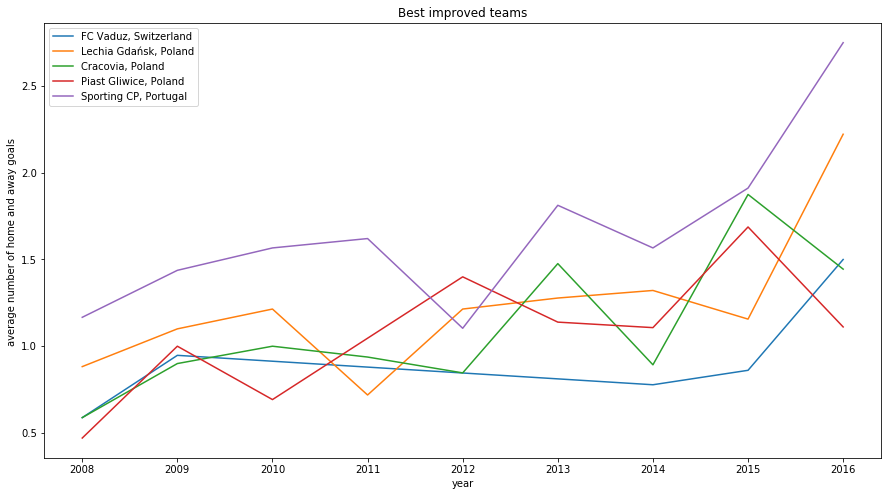

In [35]:
home_goals = goals_home_vs_away[['year', 'country_name','home_team','home_team_goal', 'home_id']]
away_goals = goals_home_vs_away[['year', 'country_name','away_team','away_team_goal', 'away_id']]
home_goals.rename(columns={'home_team' : 'team', 'home_team_goal' : 'total_goals', 'home_id' : 'id'}, inplace = True)
away_goals.rename(columns={'away_team' : 'team', 'away_team_goal' : 'total_goals', 'away_id' : 'id'}, inplace = True)
home_away_goals = home_goals.append(away_goals, ignore_index = True)

home_away_goals_avg = home_away_goals.groupby(['year', 'country_name', 'team'], as_index = False).mean()
home_away_goals_avg.to_csv('./datasets/home_away_goals.csv')
#choose 5 teams which have improved the most since 2008 until 2016
goals_ave_2008 = home_away_goals_avg.query('year == "2008"')
goals_ave_2016 = home_away_goals_avg.query('year == "2016"')
goals_ave_2008_1016 = goals_ave_2008.merge(goals_ave_2016, left_on='team', right_on='team', how='inner')
goals_ave_2008_1016.rename(columns={'year_x': 'year', 'country_name_x' : 'country_name', 'total_goals_x' : 'total_goals_2008', 'total_goals_y' : 'total_goals_2016'}, inplace = True)
goals_ave_2008_1016.drop(['year_y', 'country_name'], axis = 1, inplace=True )
goals_ave_2008_1016['ratio'] =  goals_ave_2008_1016['total_goals_2016'] / goals_ave_2008_1016['total_goals_2008']
goals_ave_2008_1016.sort_values(by='ratio', ascending=False, inplace=True)
goals_ave_2008_1016.to_csv('./datasets/goals_ave_2008_2016.csv')
year = goals_home_vs_away['year'].unique()
five_teams_best = goals_ave_2008_1016.iloc[:5,[1, 5]] #team name and ratio
five_teams_best.to_csv('./datasets/five_teams_best.csv')
fig, ax = plt.subplots(figsize=(15,8))
leg = []
for i in range(five_teams_best.shape[0]):
    team = home_away_goals_avg.query('team == "{}"'.format(five_teams_best.iloc[i,0]))
    team.sort_values(by='year')
    ax.plot(team.iloc[:,0].apply(pd.to_numeric), team.iloc[:,3])
    team.to_csv('./datasets/team.csv')
    leg.append(team.iloc[0,2]+", " + team.iloc[0, 1])
plt.xlabel('year')
plt.ylabel('average number of home and away goals ')
plt.title('Best improved teams')
plt.legend(leg)
plt.show()



This plot reveals the information about the 5 most imrpoved teams in between 2008 and 2016. Even though we can see some flatuations within the considered period, the ratio between goal average velues in 2016 and 2008 have maximum values among other teams. Therefore, the most improved team is FC Vaduz from Switzerland. 

## Reserch question № 3. Does overall performance among all teams between 2008 and 2016 was improved? 

To answer this we will find average number of combined home and away goals for each team for 2008 and 2016. Then, we will draw a bar plot with normalized values. 

C:\Users\Boris\Anaconda3\lib\site-packages\pandas\core\frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


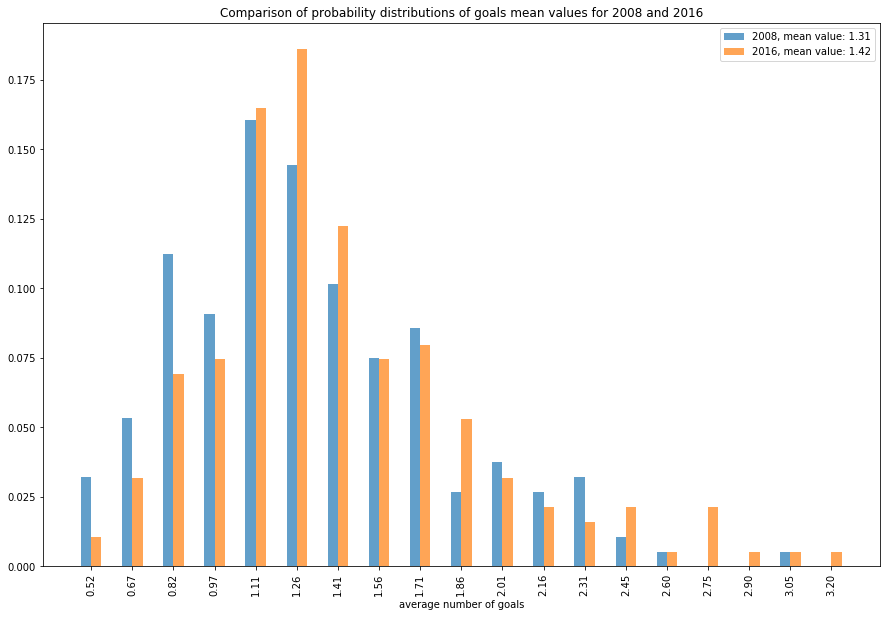

In [36]:
years = ['2008', '2016']
bins_v = 20
bin_names = []
home_goals = goals_home_vs_away[['year', 'country_name','home_team','home_team_goal', 'home_id']]
away_goals = goals_home_vs_away[['year', 'country_name','away_team','away_team_goal', 'away_id']]
home_goals.rename(columns={'home_team' : 'team', 'home_team_goal' : 'total_goals', 'home_id' : 'id'}, inplace = True)
away_goals.rename(columns={'away_team' : 'team', 'away_team_goal' : 'total_goals', 'away_id' : 'id'}, inplace = True)
home_away_goals = home_goals.append(away_goals, ignore_index = True)
home_away_goals.to_csv('./datasets/home_away_goals_1.csv')
i = 0
#intervals might not match, so define min and max values for 2 different years
for year in years:
    home_away_goals_year = home_away_goals.query('year == "{}"'.format(year))
    if i == 0:
        min = home_away_goals_year.groupby('team', as_index = False).mean().total_goals.min()
        max = home_away_goals_year.groupby('team', as_index = False).mean().total_goals.max()
    else:
        min_new = home_away_goals_year.groupby('team', as_index = False).mean().total_goals.min()
        max_new = home_away_goals_year.groupby('team', as_index = False).mean().total_goals.max()
        if min_new < min: min = min_new
        if max_new > max: max = max_new

    i += 1
#define edges
bin_edges = np.linspace(min-.00001, max+0.00001, bins_v)
#the middle of each interval
delta = (bin_edges[1] - bin_edges[0]) / 2
#declare a lost of locations
locations = []
#width of a bar
width = delta/2
#define each location
for i in range(bins_v-1):
    locations.append(bin_edges[i] + delta)
#create a plot
fig, ax = plt.subplots(figsize=(15,10))
for year in years:
    home_away_goals_local_ave = home_away_goals.query('year == "{}"'.format(year)).groupby('team').mean()
    home_away_goals_local_ave['locations'] = pd.cut(home_away_goals_local_ave['total_goals'], bin_edges, labels = locations)
    hist_data = home_away_goals_local_ave.groupby('locations', as_index=False).count()
    hist_data['total_goals'] = hist_data['total_goals'] / hist_data['total_goals'].sum()
    mean_v = format(home_away_goals_local_ave['total_goals'].mean(), ".2f")
    label_v = year +', mean value: ' + str(mean_v)
    plt.bar(locations, height = hist_data['total_goals'], alpha=0.7, width = width, label = label_v)
    for i in range(bins_v-1):
        locations[i] = locations[i] + width
label_v = []
for i in range(bins_v - 1):
    locations[i] = locations[i] - 2*width
    label_v.append(format(locations[i], '.2f'))
    locations[i] = locations[i] + width / 2
plt.title('Comparison of probability distributions of goals mean values for {} and {}'.format(years[0], years[1]))
plt.xticks(locations, label_v, rotation = 'vertical')
plt.xlabel('average number of goals')
plt.legend()
plt.show()

According to the obtained results we can see that a bar plot for 2008 looks similar to a bar plot for 2016. The mean values of these distributions are 1.31 and 1.42 respectivly for 2007 and 2016. We can see that mean value in 2016 on 0.11 higher than in 2008. This value is small, so we can say that there are only some minor improvments among all teams.  

## Research question № 4. Are there any correlations between total number of goals and team attributes? Can we find correlation between team attributes?

First, we start with plotting a matrix with all possible scatter plots. Then, we will find scatter plots which might have good correlation between parameter. 

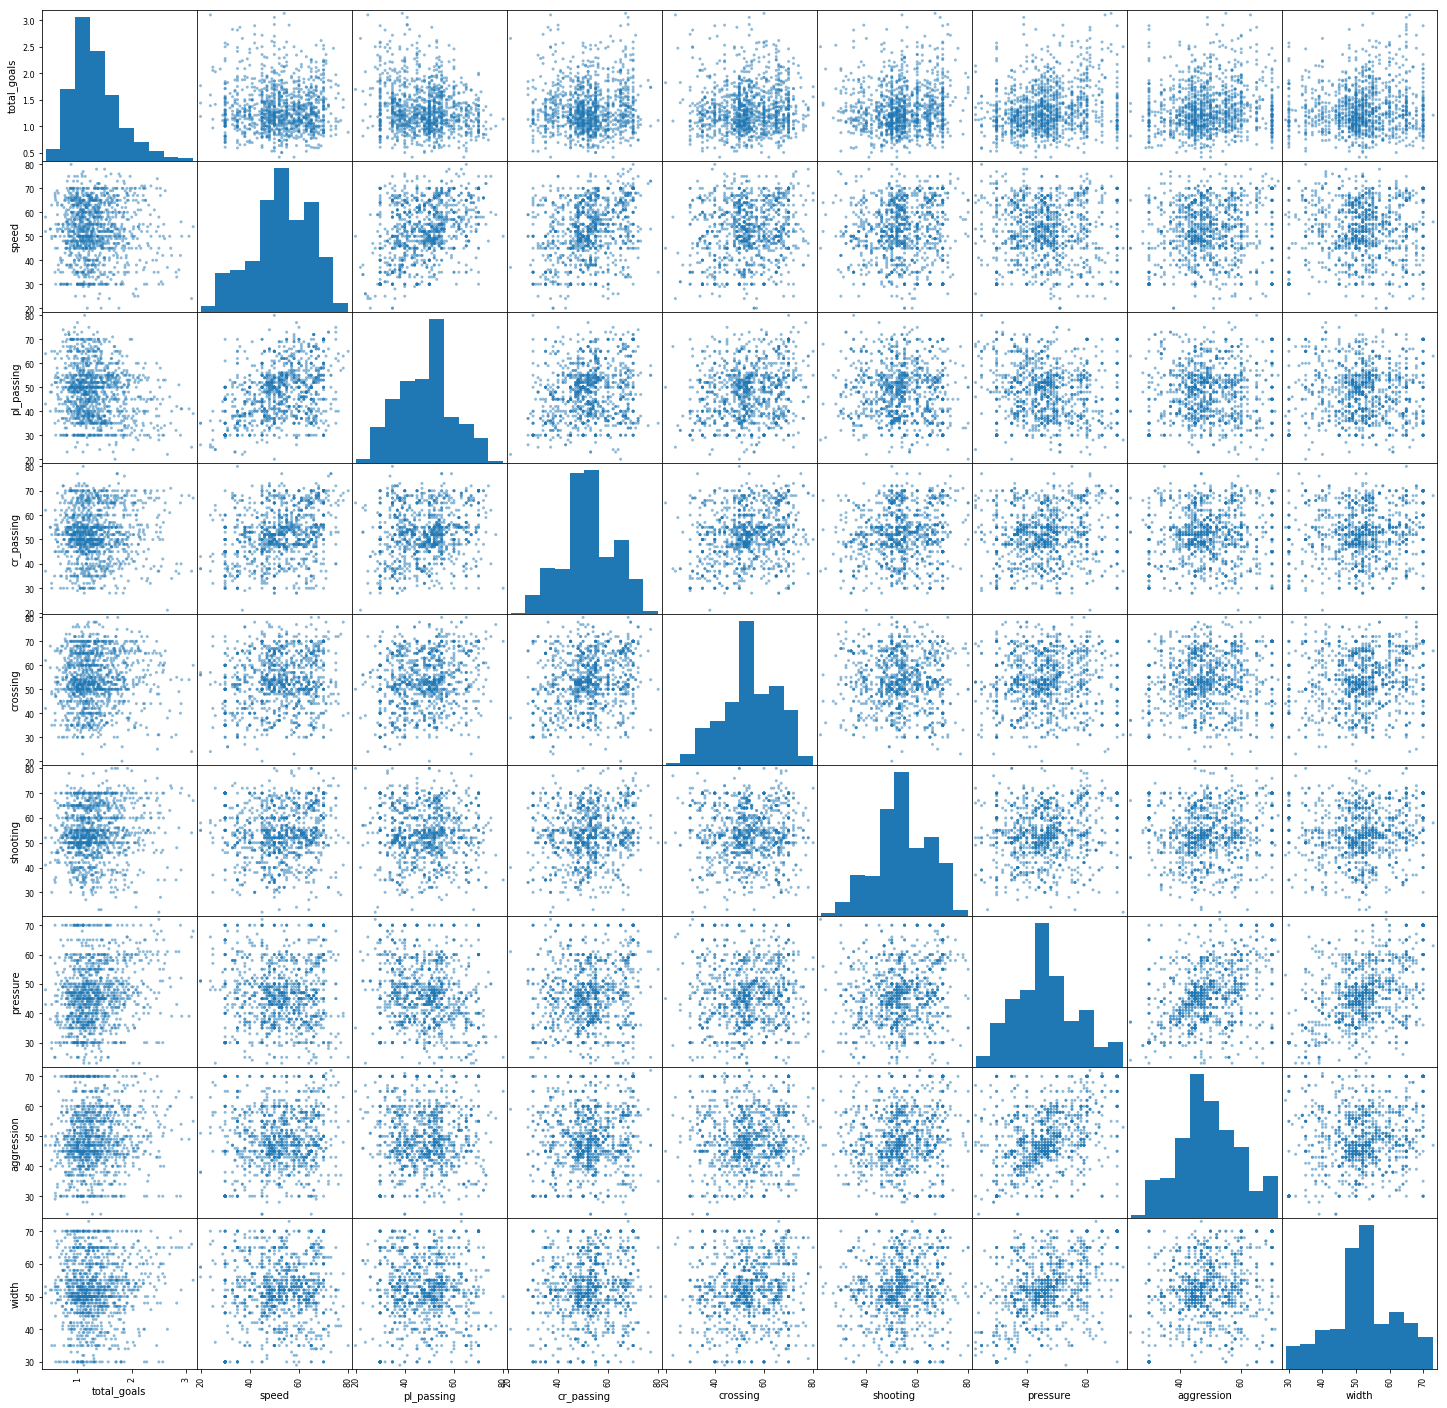

In [37]:
#group by year and id, then find means of team attributes

#merge goals and attributes
team_attributes_goals = home_away_goals.merge(team_attributes, left_on='id', right_on='id', how='inner').query("year_x == year_y")
#Export dataset to Tableau
team_attributes_goals.to_csv('./datasets/team_attributes_goals.csv')    
team_attributes_goals_ave = team_attributes_goals.groupby(['id', 'year_x' ], as_index=False).mean()

#plot it
pd.plotting.scatter_matrix(team_attributes_goals_ave.drop(columns = 'id'), figsize=(25,25));

Analyzing this matrix we cannot define strong relationships between team attributes. However, let's try to investigate the following relationships: 

Correlation coef:  -0.17934761375877675


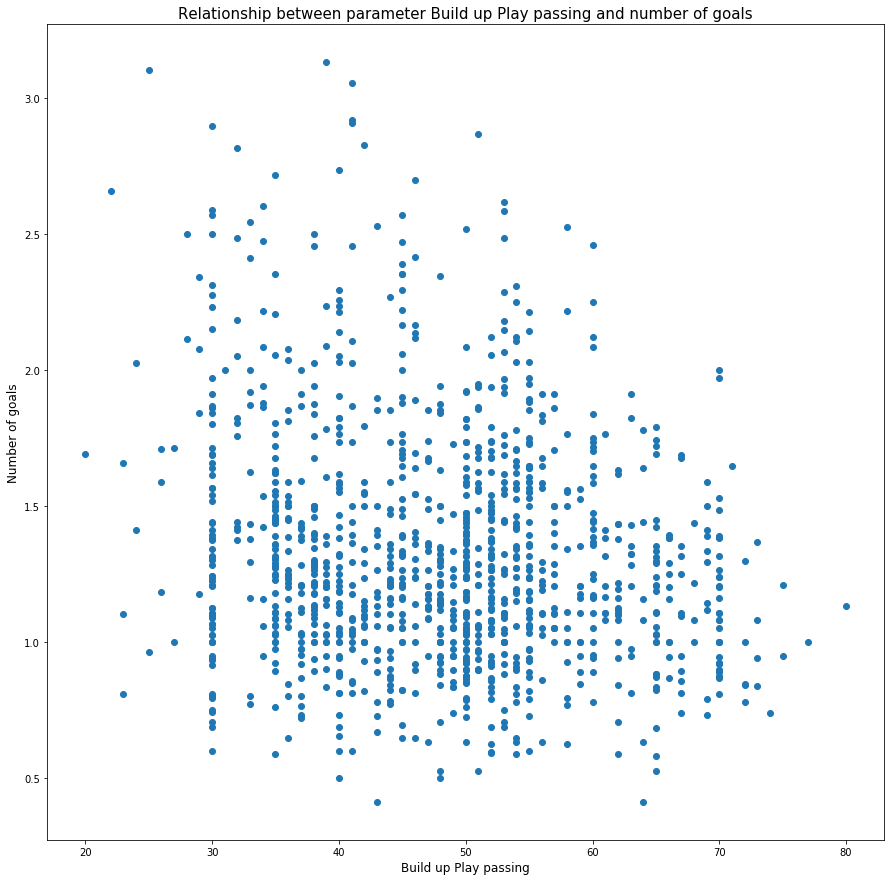

In [38]:
#plot 3 scatter plot from matrix

plt.subplots(figsize=(15,15))
plt.scatter(team_attributes_goals_ave['pl_passing'], team_attributes_goals_ave['total_goals'])
corr = np.corrcoef(team_attributes_goals_ave['pl_passing'], team_attributes_goals_ave['total_goals'])
print("Correlation coef: ", corr[0,1])
plt.title('Relationship between parameter Build up Play passing and number of goals', fontsize=15)
plt.xlabel('Build up Play passing', fontsize=12)
plt.ylabel('Number of goals', fontsize=12)
plt.show()

Correlation coef:  0.07346322784586756


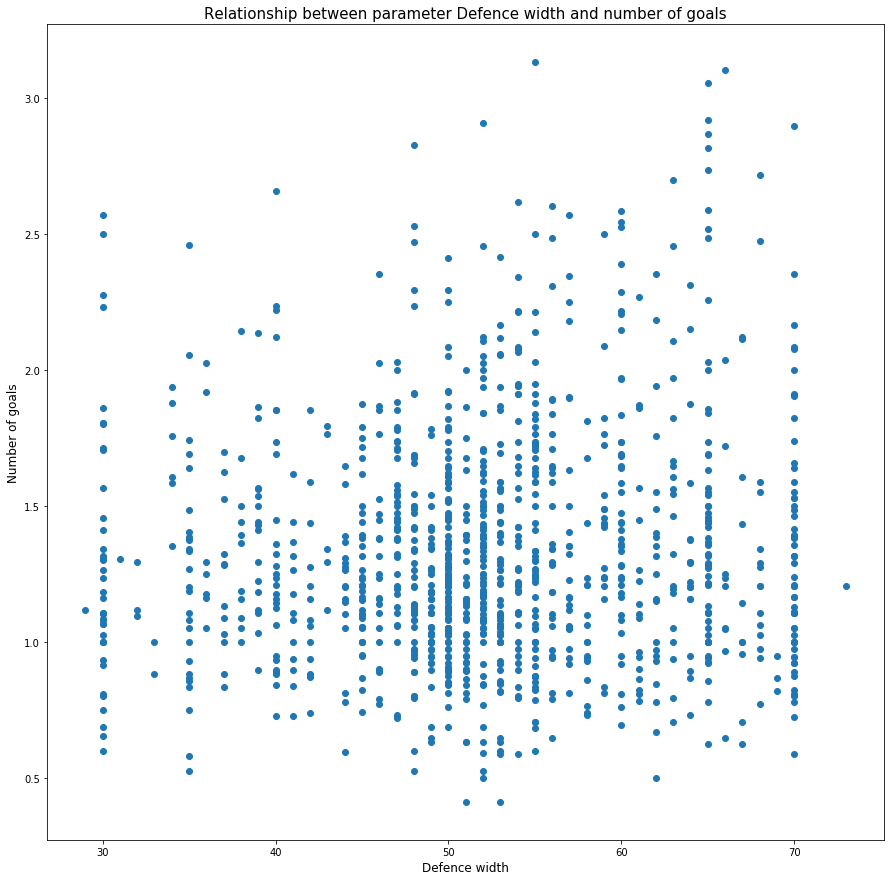

In [39]:
#plot 3 scatter plot from matrix

plt.subplots(figsize=(15,15))
plt.scatter(team_attributes_goals_ave['width'], team_attributes_goals_ave['total_goals'])
corr = np.corrcoef(team_attributes_goals_ave['width'], team_attributes_goals_ave['total_goals'])
print("Correlation coef: ", corr[0,1])
plt.title('Relationship between parameter Defence width and number of goals', fontsize=15)
plt.xlabel('Defence width', fontsize=12)
plt.ylabel('Number of goals', fontsize=12)
plt.show();

Correlation coef:  0.20351392319845188


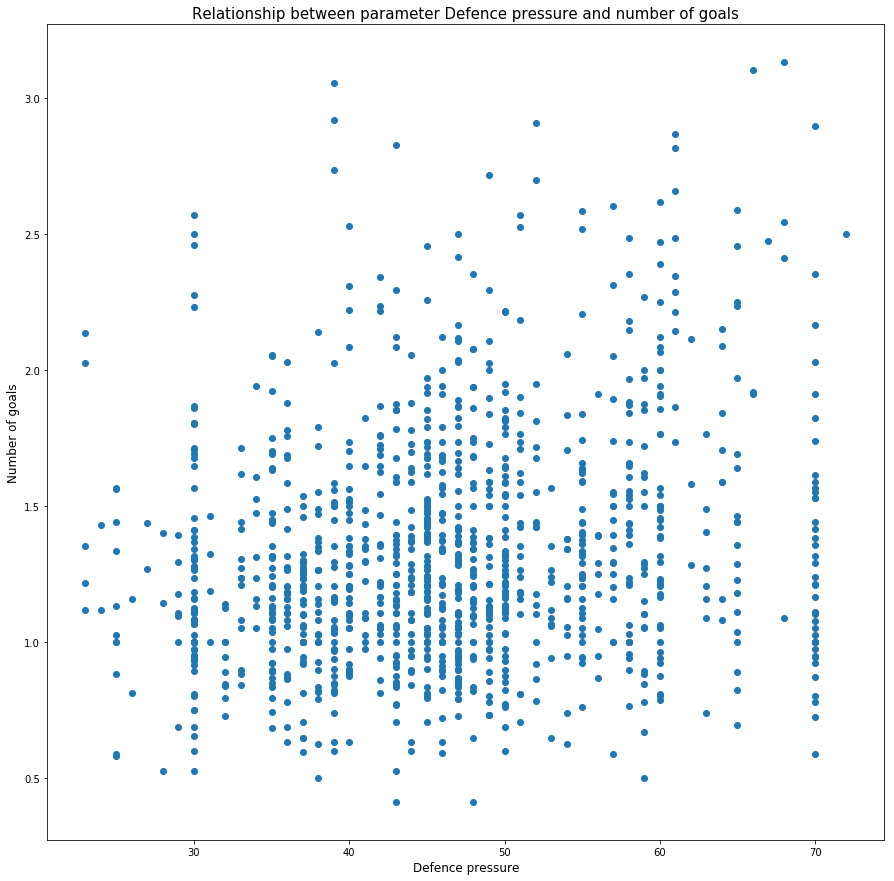

In [40]:
plt.subplots(figsize=(15,15))
plt.scatter(team_attributes_goals_ave['pressure'], team_attributes_goals_ave['total_goals'])
corr = np.corrcoef(team_attributes_goals_ave['pressure'], team_attributes_goals_ave['total_goals'])
print("Correlation coef: ", corr[0,1])
plt.title('Relationship between parameter Defence pressure and number of goals', fontsize=15)
plt.xlabel('Defence pressure', fontsize=12)
plt.ylabel('Number of goals', fontsize=12)
plt.show();

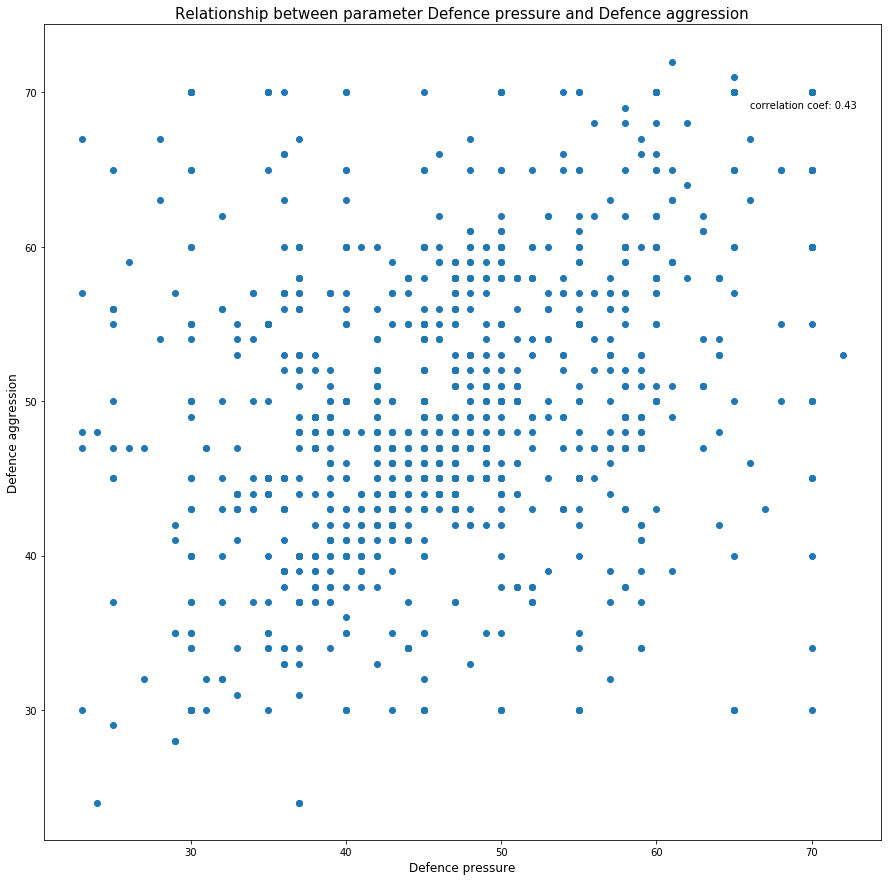

In [41]:
plt.subplots(figsize=(15,15))
plt.scatter(team_attributes_goals_ave['pressure'], team_attributes_goals_ave['aggression'])
corr = np.corrcoef(team_attributes_goals_ave['pressure'], team_attributes_goals_ave['aggression'])
plt.text(66,69, "correlation coef: " + format(corr[0,1], ".2f"))
plt.title('Relationship between parameter Defence pressure and Defence aggression', fontsize=15)
plt.xlabel('Defence pressure', fontsize=12)
plt.ylabel('Defence aggression', fontsize=12)
plt.show()

As we can see, the relationships between parameters are not strong. For the plot "Relationship between parameter Build up Play passing and number of goals" the correlation is negative negligible. Plots: "Relationship between parameter Defence width and number of goals" and "Relationship between parameter Defence pressure and number of goals" are negligibly correlated. So, we cannot say that there is an obvious relationship between any team attributes and performance. 

One can notice a relationship between defence pressure and defence aggression, a correlation coefficient equil to 0.42 which falls into low positive correlation categoty. 

One can go further and investigate dataset for each year. It can be performed here, Jupyter Notebook; however, it will be faster if we transfer our dataset to Tableau and investigate it there. A link to Tableau story is https://public.tableau.com/views/EuropeanSoccer_0/Europeansoccer?:embed=y&:display_count=yes&publish=yes . 

In Tableau we can choose a year to consider for all four scatter plots. So, let's consider all these plots one-by-one: 

1. Relationship between parameter Build up Play passing and number of goal. The following correlation coefficients are found fir each year:<br>


| year     |  corr. coef   |
|----------|:-------------:|
| 2010     |    -0.14      |
| 2011     |    -0.1       |
| 2012     |    -0.268     | 
| 2013     |    -0.176     |
| 2014     |    -0.252     |
| 2015     |    -0.178     |


    
Analysing the scatter plot for 2010 and compare it to plots from points 2 and 3 below we can say that they look quite similar, moreover, they do not look like plots for other years. Hence, it might not be a reliable source of data for 2010. These plots will be excluded from the analysis. So, the final graph looks like:

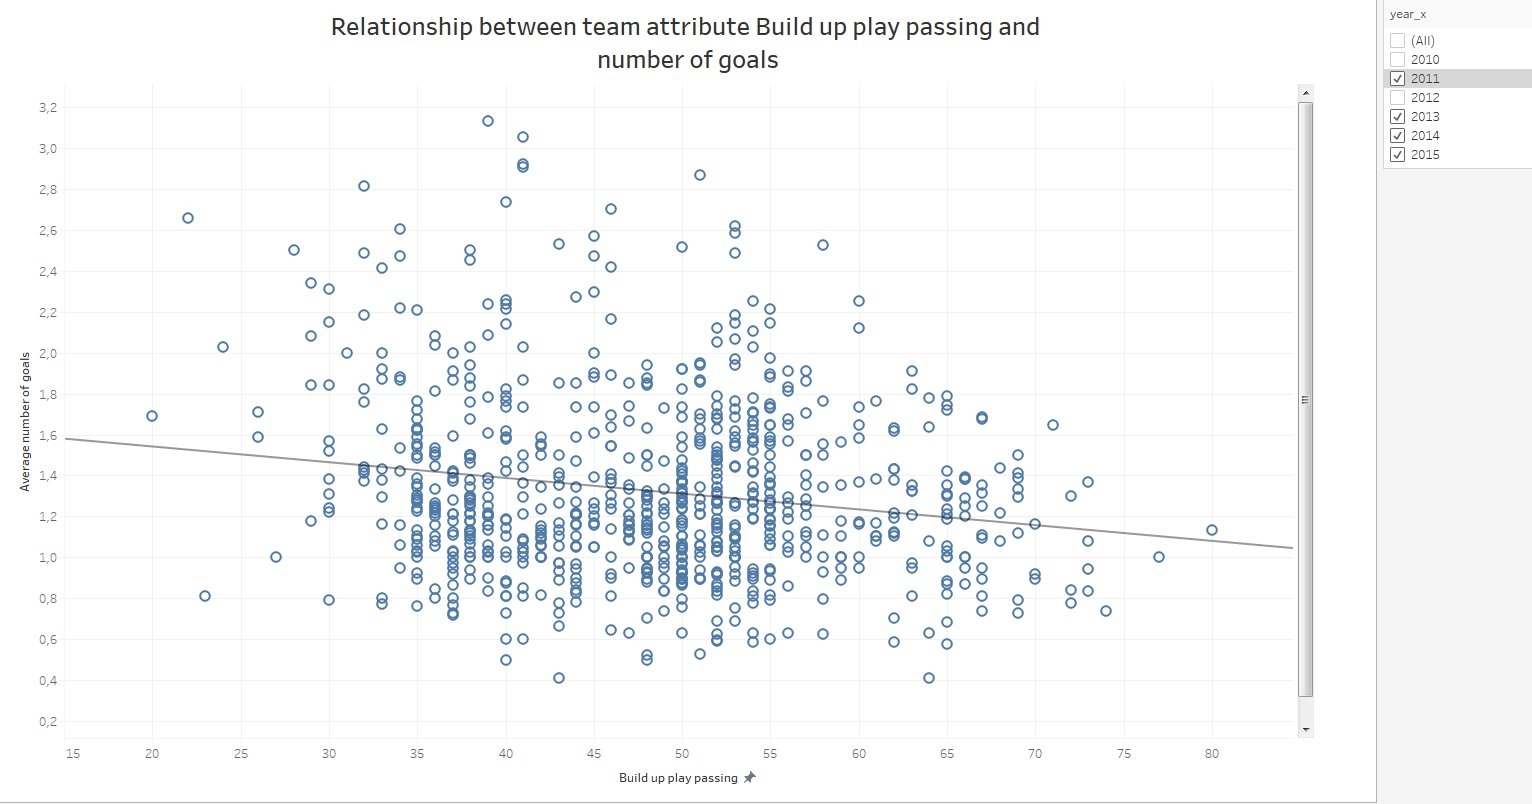

In [42]:
path = "./plots/tableau/"
Image(filename=path+"passing.jpg")
#correlation coefficient is -0.196. Which is on 0.0167 more by absolute value if we include 2010 in our analysis also.  

2. Relationship between parameter Defence width and number of goals: <br>

| year     |  corr. coef   |
|----------|:-------------:|
| 2010     |     0         |
| 2011     |     0.13      |
| 2012     |     0         | 
| 2013     |     0.1       |
| 2014     |     0.08      |
| 2015     |     0.16      |

It was mentioned above that we will exclude year 2010 from our analysis. In addition, we can see that the most correlation coefficients are about 0.1. However, correlation coeffecient for year 2012 is also 0. This year will be exclded also.   

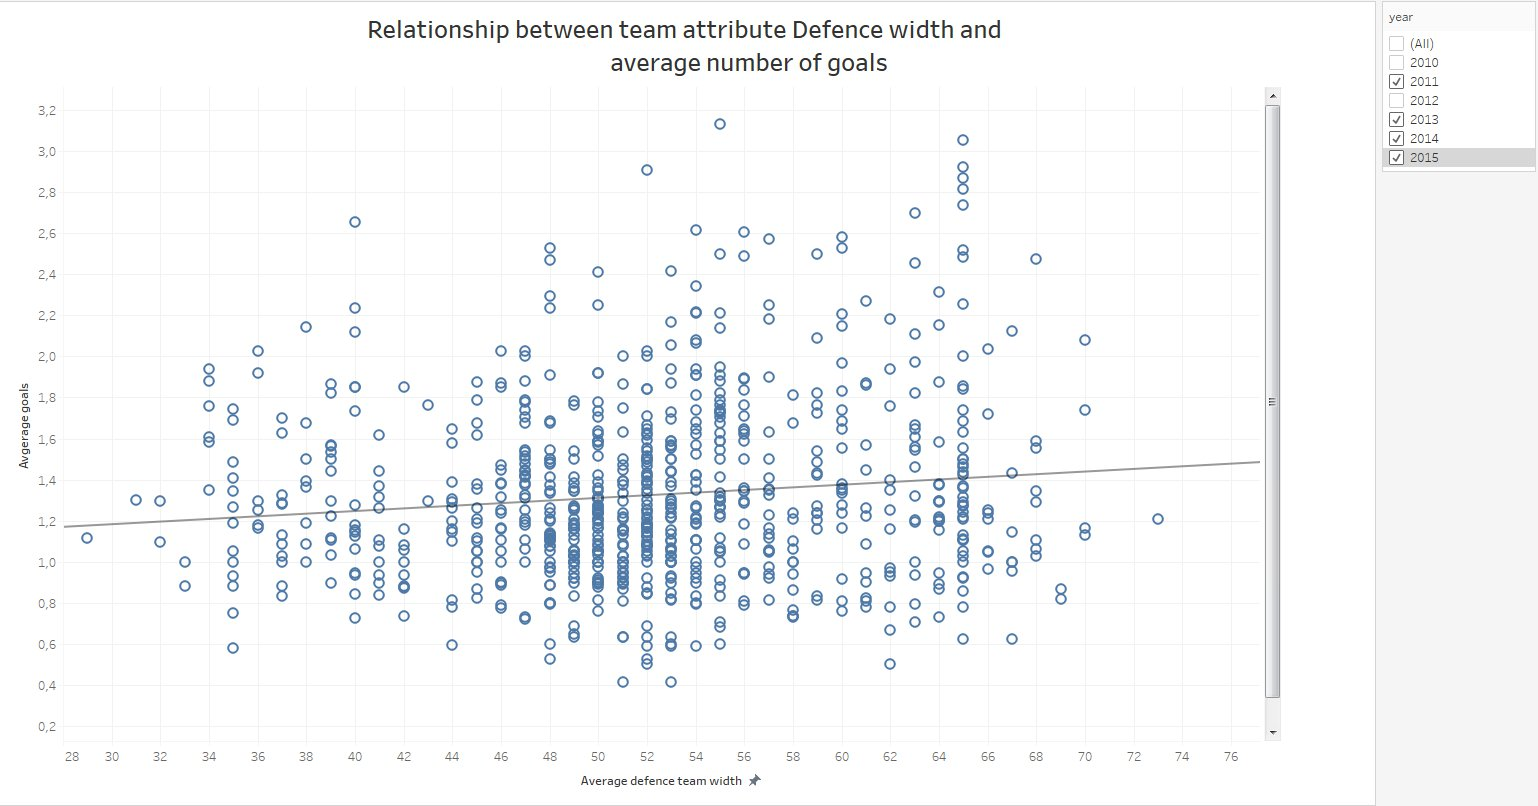

In [43]:
Image(filename=path+"width.jpg")
#correlation coefficient is 0.178. It is on 0.105 higher than if we include 2010 and 2012 years for considertions. 

3. Relationship between parameter Defence pressure and number of goals <br>

| year     |  corr. coef   |
|----------|:-------------:|
| 2010     |     0         |
| 2011     |     0.31      |
| 2012     |     0.22      | 
| 2013     |     0.26      |
| 2014     |     0.26      |
| 2015     |     0.39      |

According to the previous discussion, 2010 is excluded from the analysis. So, the final scatter plot looks like: 

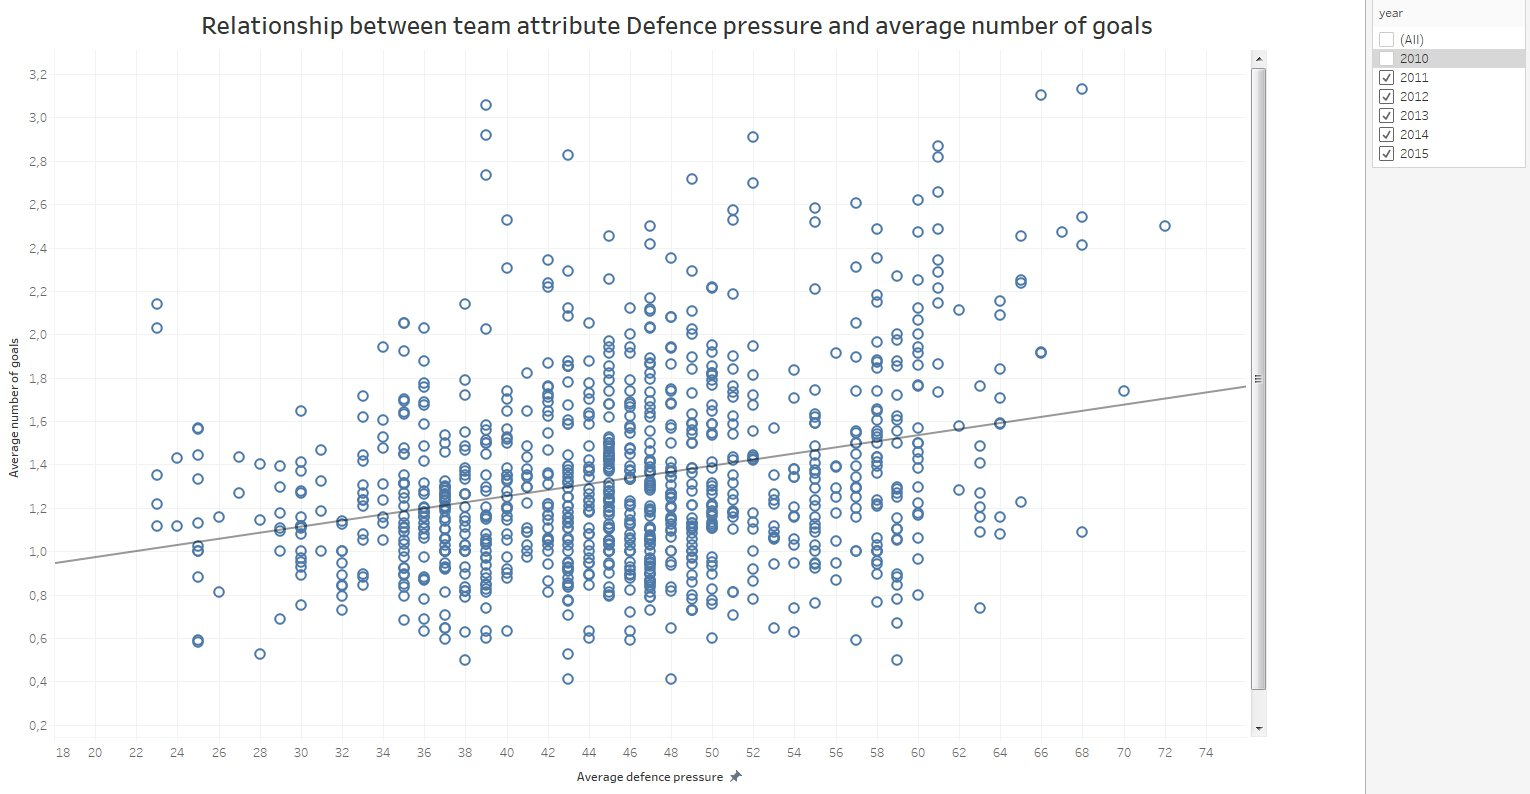

In [44]:
Image(filename=path+"pressure.jpg") 
#Correlation coefficint is 0.286. It is on 0.082 higher than if 2010 is included. 

4.  Relationship between parameter Defence pressure and Defence aggression<br>

| year     |  corr. coef   |
|----------|:-------------:|
| 2010     |     0.54      |
| 2011     |     0         |
| 2012     |     0.45      | 
| 2013     |     0.33      |
| 2014     |     0.39      |
| 2015     |     0.47      |


 Looking at the table above we can say that most correlation coefficients are higher 0.3 while it is 0 for 2011. Hence, we should exlude this year from the analysis. In addition, because we exluded year 2010 from the previous analysis, we should exclude it here as well. So, the final plot will look like: 

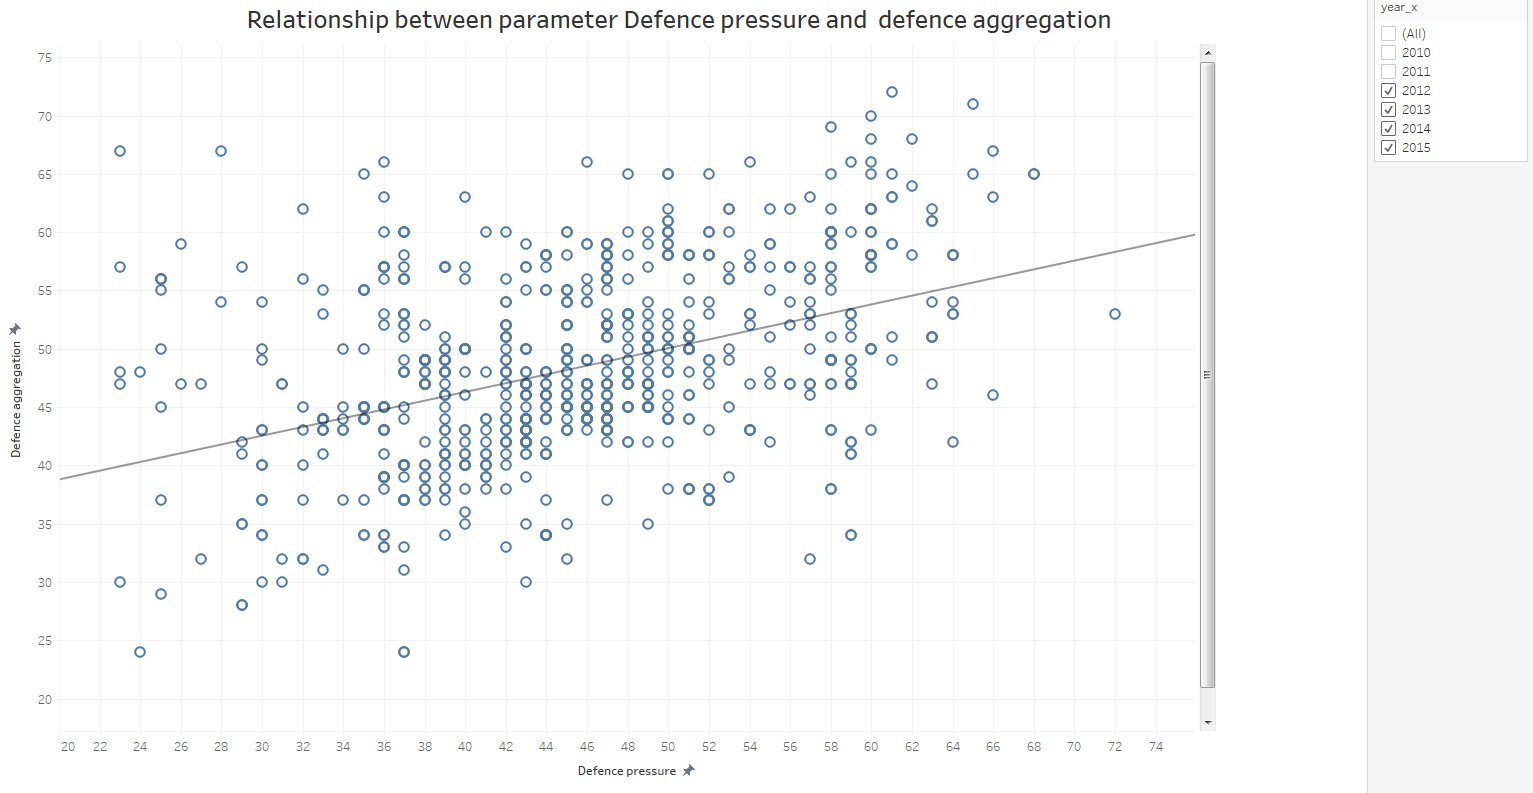

In [46]:
Image(filename=path+"presaggr.jpg") 
#Correlation coefficint is 0.413. It is on 0.017 lower than if 2010 and 2011 are included. 

Finally, we can say that we excluded unreliable datasets after we seperated the whole datasets by year and lower the influence of untrustworthy datasets. 

 <a id='conc'></a>
## Conclusion

In coclusion, we can say that a datailed data analysis has been performed. The answers to four stated questions were obtained. Firstly, we have found that home teams performed usually better than when they play away. Secondly, five best improved teams were defined in between 2008 and 2016. Then, we found that improvements between all teams in 2008 and 2016 is not significant. Finally, we found that relationships between team attributes are negligibly correlated. However, between team attributes such as defence pressure and aggression a low positive correlation is defined. 

Because trying to correlate team attributes does not give high values of correlation coefficients it would be recommended to apply ML technices which is out of schope of this project.


<a id='res'></a>
## Resources:
* Documentation for pandas, numpy, matplotlib was used
* Dima Rudov well expalined how to use DB quiries from Python scripts. https://www.kaggle.com/dimarudov/data-analysis-using-sql
* Pasting image into Jupyter Notebook: https://stackoverflow.com/questions/32370281/how-to-include-image-or-picture-in-jupyter-notebook 

Note: initially script was developed in .py file and then transferred to Jupyter Notebook. .py files also submitted as a part of the project and repo was created on GitHub https://github.com/taglitis/Soccer-database-investigation.git

#### Prepared by Boris Kushnarev for Data Analysis cources at Udacity University